In [1]:
!git clone https://github.com/parhamzm/Beijing-Pollution-DataSet

Cloning into 'Beijing-Pollution-DataSet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [2]:
!ls Beijing-Pollution-DataSet

pollution.csv  polution_dataSet.npy  README.md


In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import random_split

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from numpy import array
from numpy import hstack

# **Data Pre Processing**

In [0]:
DATA_DIR = "Beijing-Pollution-DataSet/"
from pandas import read_csv
from datetime import datetime


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps=11, n_samples=12000, start_from=0):
	X, y = list(), list()
	for i in range(start_from, (start_from + n_samples)):
        # find the end of this pattern
		end_ix = i + n_steps
        # check if we are beyond the dataset
        # gather input and output parts of the pattern
		seq_x = sequences[i:end_ix, [0, 1, 5]]
		seq_y = sequences[end_ix, 0]
		y.append(seq_y)
		X.append(seq_x)
  
	return array(X), array(y)


# load dataset
DATA_DIR = "Beijing-Pollution-DataSet/"

data = np.load(DATA_DIR + 'polution_dataSet.npy')
scaled_data = data

# specify the number of lag hours
n_hours = 11
n_features = 8
# frame as supervised learning
# reframed = series_to_supervised(scaled_data, n_hours, 1)
n_timesteps = 11
dataset = data
train_X, train_y = split_sequences(dataset, n_timesteps, n_samples=15000, start_from=0)
valid_X, valid_y = split_sequences(dataset, n_timesteps, n_samples=3000, start_from=15000)

In [5]:
test_loader_X = torch.utils.data.DataLoader(dataset=(train_X), batch_size=20, shuffle=False)
# train_X = torch.tensor(train_X, dtype=torch.float32)    
# train_y = torch.tensor(train_y, dtype=torch.float32)
print("Train X Shape :=> ", train_X.shape)
print("Train Y Shape :=> ", train_y.shape)
print("####################################")
print("Test X Shape :=> ", valid_X.shape)
print("Test Y Shape :=> ", valid_y.shape)

Train X Shape :=>  (15000, 11, 3)
Train Y Shape :=>  (15000,)
####################################
Test X Shape :=>  (3000, 11, 3)
Test Y Shape :=>  (3000,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


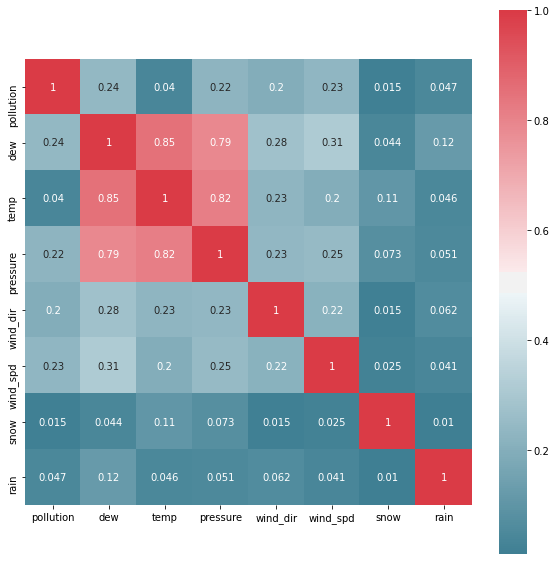

In [16]:
import seaborn as sns


seq_x = data[0:15000, 1:]
seq_y = data[0:15000, 0]

df = DataFrame(data)

plt.figure(figsize=(10, 10))
train_size = 15000 #int(df.shape[0]) #*0.8)
corr_matrix = df.iloc[:train_size,:].corr().abs()
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True, xticklabels=['pollution', 'dew','temp','pressure', 'wind_dir', 'wind_spd', 'snow', 'rain'],
            yticklabels=['pollution', 'dew','temp','pressure', 'wind_dir', 'wind_spd', 'snow', 'rain'])

In [0]:
class RNN(torch.nn.Module):
    def __init__(self, n_features=8, n_output=1, seq_length=11, n_hidden_layers=233, n_layers=1):
        super(RNN, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_output = n_output

        self.n_hidden = n_hidden_layers # number of hidden states
        self.n_layers = n_layers # number of LSTM layers (stacked)
        
        # define RNN with specified parameters
        # bath_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size=self.n_features,
                          hidden_size=self.n_hidden,
                          num_layers=self.n_layers,
                          batch_first=True)
        
        # last, fully connected layer
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, self.n_output)


    def forward(self, x, hidden):
        # hidden_state = torch.zeros(self.n_layers, x.size(0), self.n_hidden).requires_grad_()
        # cell_state = torch.zeros(self.n_layers, x.size(0), self.n_hidden).requires_grad_()
        batch_size = x.size(0)

        rnn_out, hidden = self.rnn(x, hidden)
        # print(rnn_out.shape)
        rnn_out = rnn_out.contiguous().view(batch_size, -1)
        
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        # x = lstm_out.contiguous().view(batch_size, -1)
        out = self.l_linear(rnn_out)
        return out, hidden

In [0]:
torch.manual_seed(13)
model = RNN(n_features=3, n_output=1, seq_length=11, n_hidden_layers=233, n_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0003)

In [9]:
model = model#.to(device)
criterion = criterion#.to(device)
for p in model.parameters():
    print(p.numel())

699
54289
233
233
2563
1


In [10]:
import time
start_time = time.time()
hidden = None
hidden_test = None
epochs = 100
model.train()
batch_size = 200
running_loss_history = []
val_running_loss_history = []
for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0
    model.train()
    for b in range(0, len(train_X), batch_size):
        inpt = train_X[b:b+batch_size, :, :]
        target = train_y[b:b+batch_size]

        # print("Input Shape :=> ", inpt.shape)

        x_batch = torch.tensor(inpt, dtype=torch.float32)    
        y_batch = torch.tensor(target, dtype=torch.float32)

        output, hidden = model(x_batch, hidden)

        hidden = hidden.data
        loss = criterion(output.view(-1), y_batch)

        running_loss += loss.item()

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

    else:
        with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
            model.eval()
            for b in range(0, len(valid_X), batch_size):
                inpt = valid_X[b:b+batch_size, :, :]
                target = valid_y[b:b+batch_size]   

                x_batch_test = torch.tensor(inpt, dtype=torch.float32)
                y_batch_test = torch.tensor(target, dtype=torch.float32)

                # model.init_hidden(x_batch_test.size(0))

                output_test, hidden_test = model(x_batch_test, hidden_test)

                hidden_test = hidden_test.data
                loss_valid = criterion(output_test.view(-1), y_batch_test)

                val_running_loss += loss_valid.item()

    val_epoch_loss = val_running_loss / len(valid_X)
    val_running_loss_history.append(val_epoch_loss)
    epoch_loss = running_loss / len(train_X)
    running_loss_history.append(epoch_loss)
    print('step : ' , epoch , ' Train loss : ' , epoch_loss, ', Valid Loss : => ', val_epoch_loss)
    print("***->>>-----------------------------------------------<<<-***")

total_time = time.time() - start_time
print("===========================================================")
print("*********************************************************")
print("The total Training Time is Equal with ==> : {0} Sec.".format(total_time))
print("*********************************************************")
print("===========================================================")

step :  0  Train loss :  4.937637080826486e-05 , Valid Loss : =>  3.0404661316424608e-05
***->>>-----------------------------------------------<<<-***
step :  1  Train loss :  1.5826815704349427e-05 , Valid Loss : =>  2.3403981739344695e-05
***->>>-----------------------------------------------<<<-***
step :  2  Train loss :  1.2186225882032886e-05 , Valid Loss : =>  1.7279648881716034e-05
***->>>-----------------------------------------------<<<-***
step :  3  Train loss :  1.0901659707694004e-05 , Valid Loss : =>  1.4922748475025098e-05
***->>>-----------------------------------------------<<<-***
step :  4  Train loss :  9.65917957558607e-06 , Valid Loss : =>  1.3340664736460894e-05
***->>>-----------------------------------------------<<<-***
step :  5  Train loss :  8.852214705742274e-06 , Valid Loss : =>  1.2225522620913884e-05
***->>>-----------------------------------------------<<<-***
step :  6  Train loss :  8.08726554387249e-06 , Valid Loss : =>  1.1261941981501877e-05
***-

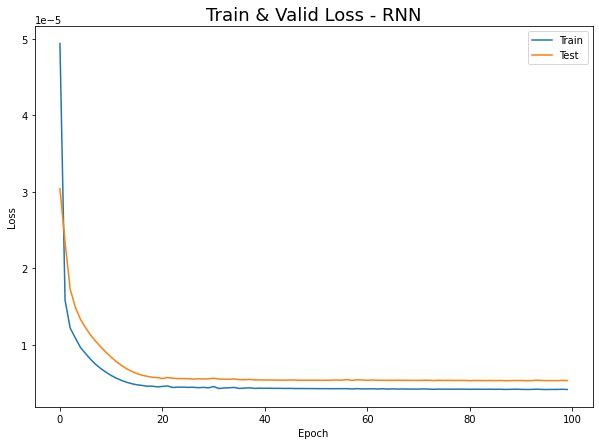

In [11]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.title("Train & Valid Loss - RNN", fontsize=18)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(running_loss_history, label='Train')
plt.plot(val_running_loss_history, label='Test')
# pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
test_x, test_y = split_sequences(dataset, n_timesteps, n_samples=3000, start_from=18000)
model.eval()


test_running_loss = 0
with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
    model.eval()
    for b in range(0, len(test_x), batch_size):
        inpt = test_x[b:b+batch_size, :, :]
        target = test_y[b:b+batch_size]   

        x_batch_test = torch.tensor(inpt, dtype=torch.float32)
        y_batch_test = torch.tensor(target, dtype=torch.float32)

        # model.init_hidden(x_batch_test.size(0))

        output_test, hidden_test = model(x_batch_test, hidden_test)

        hidden_test = hidden_test.data
        loss_test = criterion(output_test.view(-1), y_batch_test)

        test_running_loss += loss_test.item()

    test_epoch_loss = test_running_loss / len(test_x)

print("##########################################################")
print(">>>>---------------------------------------------------<<<<")
print(">>>>----------***************************--------------<<<<")
print("**** Test Loss :==>>> ", test_epoch_loss)
print(">>>>----------***************************--------------<<<<")
print(">>>>---------------------------------------------------<<<<")
print("##########################################################")

##########################################################
>>>>---------------------------------------------------<<<<
>>>>----------***************************--------------<<<<
**** Test Loss :==>>>  4.288532429200131e-06
>>>>----------***************************--------------<<<<
>>>>---------------------------------------------------<<<<
##########################################################


In [0]:
test_x, test_y = split_sequences(dataset, n_timesteps, n_samples=100, start_from=20500)
model.eval()
test_x2 = torch.tensor(test_x, dtype=torch.float32)
res, hid = model(test_x2, None)


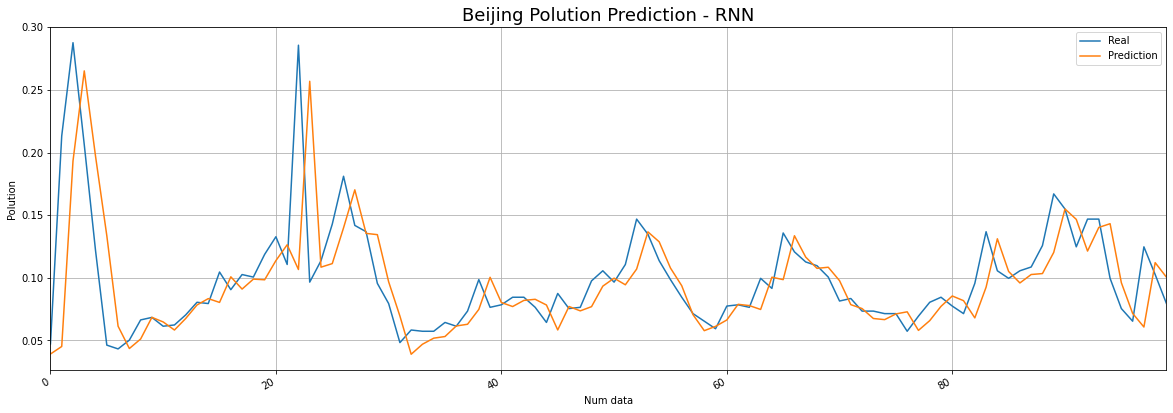

In [14]:
fig = plt.figure(figsize=(20, 7))
plt.title("Beijing Polution Prediction - RNN", fontsize=18)
plt.ylabel('Polution')
plt.xlabel('Num data')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()
plt.plot(test_y, label="Real")
plt.plot(res.detach().numpy(), label="Prediction")
plt.legend()
plt.show()

In [0]:
# split a multivariate sequence into samples
def split_sequences12(sequences, n_steps, n_samples=12000, start_from=0):
    X, y = list(), list()
    j = 0
    for i in range(start_from, (start_from + n_samples)):
        # find the end of this pattern
        end_ix = j*12 + n_steps + start_from
        # check if we are beyond the dataset
        # gather input and output parts of the pattern
        j = j + 1
        seq_x = sequences[end_ix-11:end_ix, :]
        seq_y = sequences[end_ix, 0]
        y.append(seq_y)
        X.append(seq_x)
    print("End :=> ", end_ix)
    return array(X), array(y)